In [ ]:
import pandas as pd

summary_features = pd.read_csv('/content/participant_summary_new.csv')
#summary_features = pd.read_csv('/content/drive/My Drive/full_participant_summary.csv')

print(summary_features.shape)

(275, 1000)


In [ ]:
new_names = []
for i in range(1, 50):  # f1 to f49
    for stat in ['mean', 'std', 'min', 'max']:
        new_names.append(f'OpenFace_f{i}_{stat}')

# Apply renaming to your dataframe
column_indices_to_rename = range(802, 998)  # Inclusive of 802 to 997
summary_features.columns.values[list(column_indices_to_rename)] = new_names

In [ ]:
summary_features = summary_features.loc[:, (summary_features != 0).any(axis=0)]

In [ ]:
summary_features.shape

(275, 782)

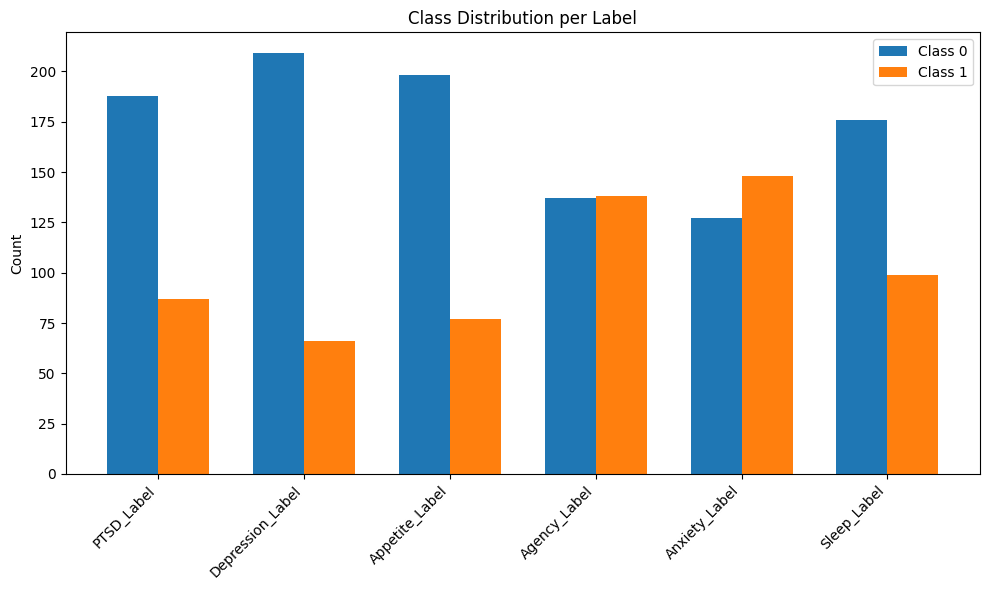

In [ ]:
import matplotlib.pyplot as plt

# Load your label CSV
df = pd.read_csv('/content/GroundTruth Table.csv')

# Define labels
labels = ['PTSD_Label',	'Depression_Label',	'Appetite_Label',	'Agency_Label',	'Anxiety_Label',	'Sleep_Label']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(labels))
zeros = [df[label].value_counts().get(0, 0) for label in labels]
ones = [df[label].value_counts().get(1, 0) for label in labels]

bar_width = 0.35
ax.bar([i - bar_width/2 for i in x], zeros, width=bar_width, label='Class 0')
ax.bar([i + bar_width/2 for i in x], ones, width=bar_width, label='Class 1')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Class Distribution per Label')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Separate features (summary_features) and the identified labels
X = summary_features
# y = df[labels[0]] #i =0, 1, 2, 3, 4, 5 for different targets

# # Initialize StratifiedKFold with 5 splits
# n_splits = 5  # Set to 5 for 5 iterations/folds
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
X = summary_features.copy()

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [ ]:
X.shape

(275, 782)

In [ ]:
from sklearn.feature_selection import mutual_info_classif


In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

    return mi_scores

# mi_scores = make_mi_scores(X, y, discrete_features)
# mi_scores  # show a few features with their MI scores

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load data
df = pd.read_csv('/content/GroundTruth Table.csv')
labels = ['PTSD_Label', 'Depression_Label', 'Appetite_Label', 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']
model_names = ['Logistic Regression', 'MLP', 'XGBoost', 'SVM', 'Ridge']
THRESHOLD = 0.3  # Can be tuned further

# Dictionary to collect all metrics
results = {model: [] for model in model_names}

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn) if (tp + fn) else 0
    spec = tn / (tn + fp) if (tn + fp) else 0
    return round(acc, 4), round(sens, 4), round(spec, 4)

for label in labels:
    print(f"\n=== Processing label: {label} ===")
    X = summary_features.copy()
    y = df[label]

    discrete_features = [False] * X.shape[1]
    mi_scores = make_mi_scores(X, y, discrete_features)
    filtered_scores = mi_scores[mi_scores > 0]
    filtered_X = X[filtered_scores.index]

    # Drop highly correlated features
    corr_matrix = filtered_X.corr().abs()
    to_drop = {
        col2 if filtered_scores[col1] >= filtered_scores[col2] else col1
        for i, col1 in enumerate(corr_matrix.columns)
        for j, col2 in enumerate(corr_matrix.columns)
        if i < j and corr_matrix.loc[col1, col2] > 0.8
    }

    final_X = filtered_X.drop(columns=to_drop)
    final_scores = filtered_scores.drop(labels=to_drop)

    # Select top 20% features
    top_features = final_scores.sort_values(ascending=False).head(int(len(final_scores) * 0.2))
    X = final_X[top_features.index]

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    label_results = {model: {'acc': [], 'sens': [], 'spec': []} for model in model_names}

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Standardize
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Apply SMOTE
        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Define models
        classifiers = {
            'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=10000),
            'MLP': MLPClassifier(hidden_layer_sizes=(16,), activation='relu', max_iter=10000),
            'XGBoost': XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
            'SVM': SVC(kernel='rbf', probability=True, class_weight='balanced'),
            'Ridge': RidgeClassifier(class_weight='balanced')
        }

        for model_name, model in classifiers.items():
            # Set scale_pos_weight for XGBoost manually
            if model_name == "XGBoost":
                pos = np.sum(y_resampled == 1)
                neg = np.sum(y_resampled == 0)
                model.set_params(scale_pos_weight=neg / pos)

            model.fit(X_resampled, y_resampled)

            # Predict probabilities if available
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                y_pred = (y_prob >= THRESHOLD).astype(int)
            else:
                y_decision = model.decision_function(X_test)
                y_prob = 1 / (1 + np.exp(-y_decision))  # Sigmoid for SVM/Ridge
                y_pred = (y_prob >= THRESHOLD).astype(int)

            acc, sens, spec = compute_metrics(y_test, y_pred)
            label_results[model_name]['acc'].append(acc)
            label_results[model_name]['sens'].append(sens)
            label_results[model_name]['spec'].append(spec)

    # Average across folds
    for model in model_names:
        acc = np.mean(label_results[model]['acc'])
        sens = np.mean(label_results[model]['sens'])
        spec = np.mean(label_results[model]['spec'])
        results[model].extend([acc, sens, spec])

# Build final summary table
columns = [
    f'{label.split("_")[0]}_{metric}'
    for label in labels
    for metric in ['accuracy', 'sensitivity', 'specificity']
]

summary_df = pd.DataFrame.from_dict(results, orient='index', columns=columns)
summary_df.index.name = "Model"

print("\n===== Final Summary Table with SMOTE + Thresholding + Class Weights =====")
print(summary_df)
summary_df.to_csv("classification_summary.csv")



=== Processing label: PTSD_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


=== Processing label: Depression_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


=== Processing label: Appetite_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


=== Processing label: Agency_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


=== Processing label: Anxiety_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


=== Processing label: Sleep_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:22:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


===== Final Summary Table with SMOTE + Thresholding + Class Weights =====
                     PTSD_accuracy  PTSD_sensitivity  PTSD_specificity  \
Model                                                                    
Logistic Regression        0.49454           0.53072           0.47894   
MLP                        0.58912           0.39280           0.68138   
XGBoost                    0.57818           0.49280           0.61678   
SVM                        0.60728           0.52876           0.64382   
Ridge                      0.41090           0.83790           0.21224   

                     Depression_accuracy  Depression_sensitivity  \
Model                                                              
Logistic Regression              0.61820                 0.60770   
MLP                              0.66910                 0.50000   
XGBoost                          0.68364                 0.43736   
SVM                              0.72728                 0.43844  

# Model for Temporal Features (CNN+BILSTM)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, BatchNormalization, GlobalMaxPooling1D, Dropout
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
y_all.shape

NameError: name 'y_all' is not defined

In [ ]:
X_all = pd.read_csv('/content/All_features.csv', usecols = extracted_features)
y_all = y
print(X_all.shape)
X_all = np.array(X_all)
X_all = X_all.reshape(275, 87, -1)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y
)
MAX_CHUNKS = 87

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Bidirectional, LSTM, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# Wrap your model in a function
def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# K-fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_accuracies = []

for train_index, test_index in kf.split(X_all, y_all):
    print(f"\nTraining Fold {fold}")
    X_train, X_test = X_all[train_index], X_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]

    model = build_model(input_shape=(MAX_CHUNKS, X_all.shape[2]))
    model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test), verbose=1)

    # Evaluate
    preds = (model.predict(X_test) > 0.5).astype("int32")
    acc = accuracy_score(y_test, preds)
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    all_accuracies.append(acc)
    fold += 1

# Average accuracy
print(f"\nAverage Accuracy over 5 folds: {np.mean(all_accuracies):.4f}")
